In [41]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from io import BytesIO

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [42]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg_model = models.vgg19(pretrained=True)
vgg_features = vgg_model.features

# Freeze all parameters in the VGG19 feature extraction layers as we dont want to update the weights
for param in vgg_features.parameters():
    param.requires_grad = False

# Check if cuda available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [44]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    size = min(max(image.size), max_size) if shape is None else shape

    transform_pipeline = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Apply transformations, discard alpha channel if present, and add batch dimension
    image = transform_pipeline(image)[:3, :, :].unsqueeze(0)

    return image

In [45]:
#Paths to image

original = load_image('/content/Tuebingen_Neckarfront.jpg').to(device)
style = load_image('/content/wave_crop.jpg', shape=original.shape[-2:]).to(device)

Text(0.5, 1.0, 'STYLE')

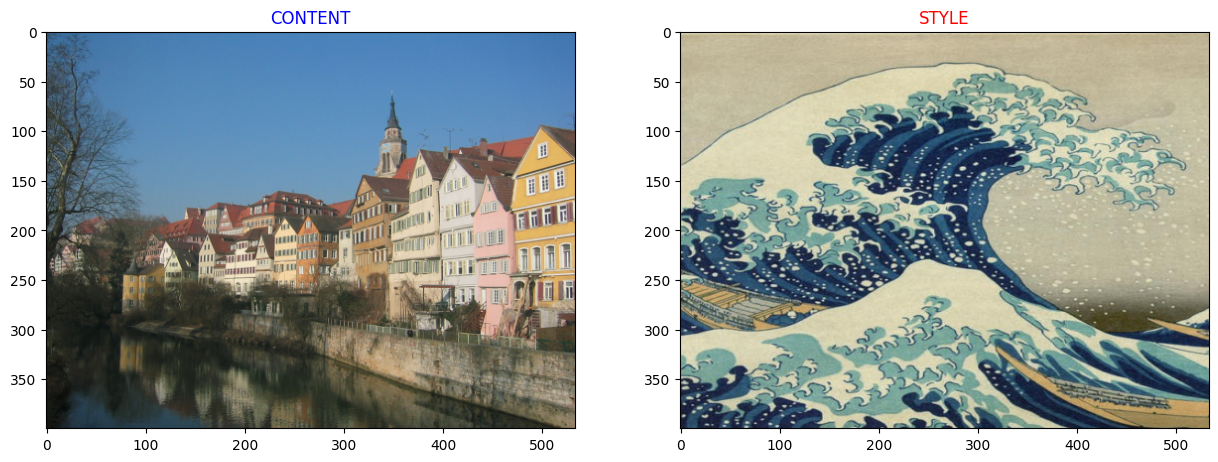

In [70]:
def im_convert(tensor):
    #  Display a tensor as an image.

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)

    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    image = image * std + mean

    image = image.clip(0, 1)

    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(original))
ax2.imshow(im_convert(style))

ax1.set_title('CONTENT', color='b')
ax2.set_title('STYLE', color='r')

In [55]:
def get_features(image, model):
    # Get features from mentioned layers
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2', #representation
              '28': 'conv5_1'}

    features = {}
    x = image

    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


def gram_matrix(tensor):

    # Calculate the Gram Matrix of a given tensor
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [56]:
# Get original and style features
original_features = get_features(original, vgg_features)
style_features = get_features(style, vgg_features)

# Starting with the generated as a copy of our original image
generated = original.clone().requires_grad_(True).to(device)

In [57]:
# iteration hyperparameters
optimizer = optim.Adam([generated], lr=0.003)
iterations = 3000
alpha = 1
beta = 1e6
layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

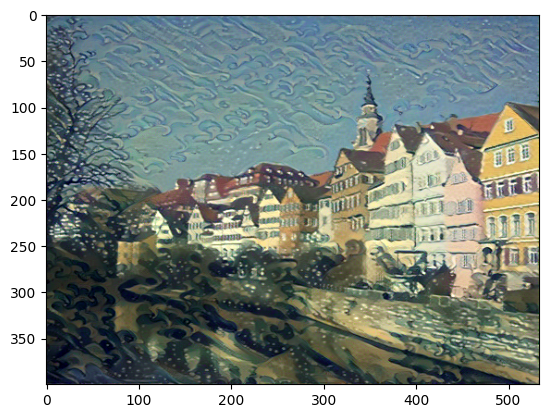

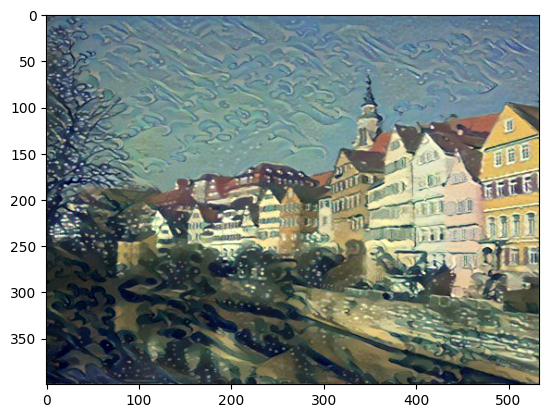

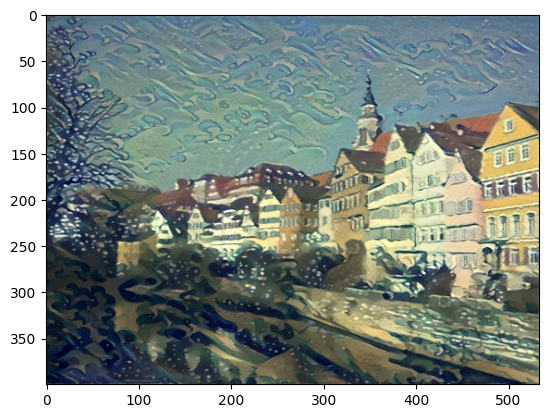

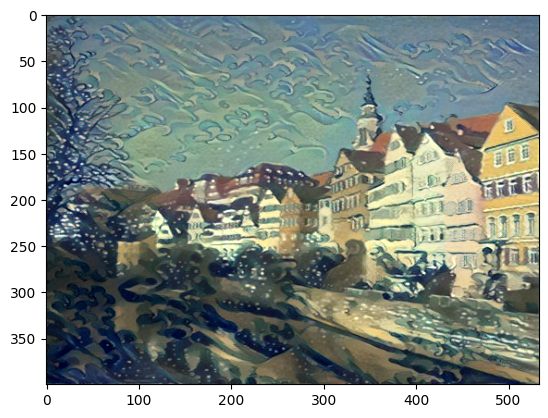

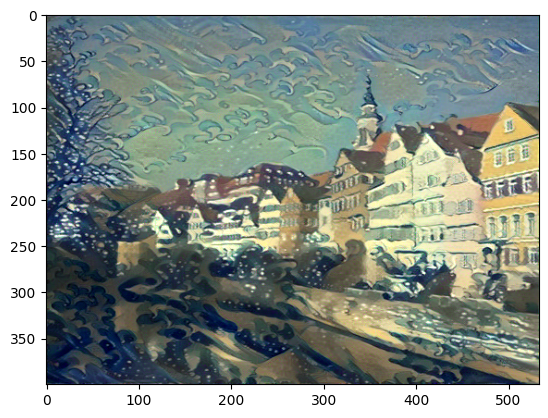

In [59]:
for steps in range(1, iterations):

    # get the features from your target image
    generated_feature = get_features(generated, vgg_features)

    # the content loss
    original_loss = torch.mean((generated_feature['conv4_2'] - original_features['conv4_2'])**2)

    # initialize the style loss to 0
    style_loss = 0

    # then add to it for each layer's gram matrix loss
    for layer in layers:

        _, d, h, w = generated_feature[layer].shape

        # GRAM MATRIX FOR TARGET
        target_gram = gram_matrix(generated_feature[layer])
        # GRAM MATRIX FOR STYLE
        style_grams = gram_matrix(style_features[layer])

        style_loss +=  torch.mean((target_gram - style_grams)**2) / (d * h * w)

    # Total loss
    total_loss = alpha * original_loss + beta * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    # display intermediate images
    if  steps % 500 == 0:
        plt.imshow(im_convert(generated))
        plt.show()

Text(0.5, 1.0, 'GENERATED')

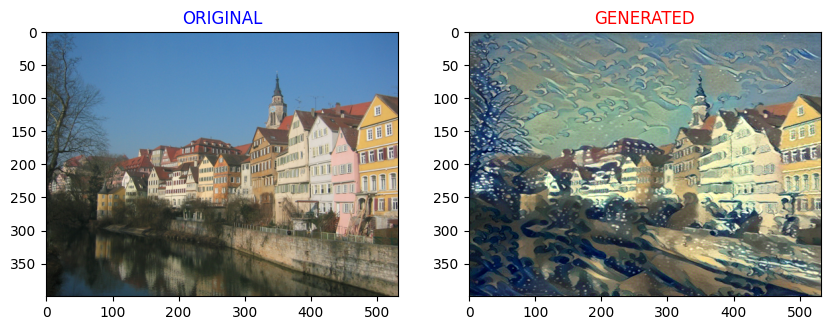

In [69]:
# display original and final
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(im_convert(original))
ax2.imshow(im_convert(generated))

ax1.set_title('ORIGINAL', color='b')
ax2.set_title('GENERATED', color='r')